In [11]:
# Import packages
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,LSTM,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import *

In [33]:
# Read in data
turnout = pd.read_csv("data/National_Turnout_1789_2018.csv", usecols = [0,1])

In [35]:
print(turnout)
X = np.array(turnout['Turnout'].values.astype('float32')).reshape(turnout.shape[0],1)
print(X.shape)

     Year  Turnout
0    1789     11.6
1    1790     21.6
2    1792      6.3
3    1794     25.0
4    1796     20.1
..    ...      ...
111  2010     41.0
112  2012     58.6
113  2014     36.7
114  2016     60.1
115  2018     50.0

[116 rows x 2 columns]
(116, 1)


In [36]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.express as px

# UTILITY
def plotly_line_plot(t,y,title="Plot",x_label="t: time (months)",y_label="y(t): Response variable"):

    # GENERATE PLOTLY FIGURE
    fig = px.line(x=t[0],y=y[0], title=title, render_mode='SVG')  
    # IMPORTANT: SVG FIXES RENDER ISSUES WITH SAD FACE 
    # https://community.plotly.com/t/plotly-express-line-charts-are-not-shown/39715
    
    # ADD MORE
    for i in range(1,len(y)):
        if len(t[i])==1:
            #print(t[i],y[i])
            fig.add_scatter(x=t[i],y=y[i])
        else:
            fig.add_scatter(x=t[i],y=y[i], mode='lines')

    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        showlegend=False
    )
    fig.show()


In [39]:
# SINGLE SERIES 
t=[*range(0,len(X))]
plotly_line_plot([t],[X[:,0]],title="National Turnout", x_label = "Years", y_label = "Turnout")

In [40]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(X)

print(train_data.shape)
print(test_data.shape)

(92,)
(24,)


In [46]:
# SINGLE SERIES 
t1=[*range(0,len(train_data))]
t2=len(train_data)+np.array([*range(0,len(test_data))])
plotly_line_plot([t1,t2],[train_data,test_data],title="National Turnout", x_label = "Years", y_label = "Turnout")

In [42]:
# PREPARE THE INPUT X AND TARGET Y
def get_XY(dat, time_steps,plot_data_partition=False):
    global X_ind,X,Y_ind,Y #use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps); #print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind=[*range(time_steps*rows_x)]
    del X_ind[::time_steps] #if time_steps=10 remove every 10th entry
    X = dat[X_ind]; 

    #PLOT
    if(plot_data_partition):
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y,'o',X_ind, X,'-'); plt.show(); 

    #RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps-1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y


#PARTITION DATA
p=10 # simpilar to AR(p) given time_steps data points, predict time_steps+1 point (make prediction one month in future)

testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [43]:
print(testX.shape,testY.shape)
print(trainX.shape,trainY.shape)
print(type(trainX))

(2, 9, 1) (2,)
(9, 9, 1) (9,)
<class 'numpy.ndarray'>


In [48]:
## Build list 
tmp1=[]; tmp2=[]; tmp3=[]; count=0
for i in range(0,trainX.shape[0]):
    # tmp1.append()
    tmp1.append(count+np.array([*range(0,trainX[i,:,0].shape[0])]))
    tmp1.append([count+trainX[i,:,0].shape[0]]); #print(([count+trainX[i,:,0].shape[0]]))
    # tmp1.append([count+trainX[i,:,0].shape[0]+1])
    tmp2.append(trainX[i,:,0])
    tmp2.append([trainY[i]]); #print([trainY[i]])
    # tmp2.append([trainY[i]])

    count+=trainX[i,:,0].shape[0]+1

    # print(i,trainX[i,:,0].shape)
# print(tmp1)
# print(tmp2)
plotly_line_plot(tmp1,tmp2,title="National Turnout", x_label = "Years", y_label = "Turnout")

In [49]:
#USER PARAM
recurrent_hidden_units=3
epochs=60
f_batch=0.2    #fraction used for batch size
optimizer="RMSprop"
validation_split=0.2
print(trainX.shape,p,trainY.shape)

# trainY=trainY.reshape(trainY.shape[0],1)
# testY=testY.reshape(testY.shape[0],1)
print(p,trainX.shape,testX.shape,trainY.shape,testY.shape)

(9, 9, 1) 10 (9,)
10 (9, 9, 1) (2, 9, 1) (9,) (2,)


In [50]:
from tensorflow.keras import regularizers


#CREATE MODEL
model = Sequential()
#COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
# model.add(SimpleRNN(
# model.add(GRU(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(1e-1),
activation='tanh')
          ) 
     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# COMPILE THE MODEL 
model.compile(loss='MeanSquaredError', optimizer=optimizer)
model.summary()


2023-04-28 15:47:37.583312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [51]:

#TRAIN MODEL
history = model.fit(
trainX, trainY, 
epochs=epochs, 
batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/60
7/7 - 2s - loss: 1.2467 - val_loss: 0.9492 - 2s/epoch - 247ms/step
Epoch 2/60
7/7 - 0s - loss: 1.1612 - val_loss: 0.8905 - 38ms/epoch - 5ms/step
Epoch 3/60
7/7 - 0s - loss: 1.0976 - val_loss: 0.8389 - 36ms/epoch - 5ms/step
Epoch 4/60
7/7 - 0s - loss: 1.0415 - val_loss: 0.7943 - 43ms/epoch - 6ms/step
Epoch 5/60
7/7 - 0s - loss: 0.9891 - val_loss: 0.7494 - 34ms/epoch - 5ms/step
Epoch 6/60
7/7 - 0s - loss: 0.9391 - val_loss: 0.7090 - 41ms/epoch - 6ms/step
Epoch 7/60
7/7 - 0s - loss: 0.8929 - val_loss: 0.6703 - 42ms/epoch - 6ms/step
Epoch 8/60
7/7 - 0s - loss: 0.8480 - val_loss: 0.6329 - 36ms/epoch - 5ms/step
Epoch 9/60
7/7 - 0s - loss: 0.8054 - val_loss: 0.5982 - 43ms/epoch - 6ms/step
Epoch 10/60
7/7 - 0s - loss: 0.7645 - val_loss: 0.5639 - 44ms/epoch - 6ms/step
Epoch 11/60
7/7 - 0s - loss: 0.7251 - val_loss: 0.5320 - 40ms/epoch - 6ms/step
Epoch 12/60
7/7 - 0s - loss: 0.6869 - val_loss: 0.5000 - 43ms/epoch - 6ms/step
Epoch 13/60
7/7 - 0s - loss: 0.6504 - val_loss: 0.4705 - 40ms

1/1 [==============================] - 0s 16ms/step
(9, 9, 1) (9,) (9,) (2, 9, 1) (2,) (2,)
(9,) (9,)
0.020332538
0.0050443225
Train MSE = 0.02033 RMSE = 0.14259
Test MSE = 0.00504 RMSE = 0.07102


[1.2466775178909302, 1.1612032651901245, 1.0976167917251587, 1.0414901971817017, 0.9890633821487427, 0.9390593767166138, 0.8929229974746704, 0.8479655385017395, 0.8054304122924805, 0.7645049095153809, 0.7250964045524597, 0.6868548393249512, 0.6504383683204651, 0.6156352162361145, 0.5817431211471558, 0.5489367842674255, 0.5177151560783386, 0.4878213703632355, 0.4587347209453583, 0.4304993450641632, 0.4033813774585724, 0.3770967423915863, 0.35176795721054077, 0.32665637135505676, 0.3018396496772766, 0.2782173454761505, 0.2552121579647064, 0.2332700788974762, 0.2118276208639145, 0.19226324558258057, 0.17438217997550964, 0.157695934176445, 0.14242133498191833, 0.1286441683769226, 0.11615560948848724, 0.10541322082281113, 0.09620020538568497, 0.08788442611694336, 0.08086215704679489, 0.07499460130929947, 0.06985139101743698, 0.06530224531888962, 0.06110384315252304, 0.05769907683134079, 0.05494687706232071, 0.05240148678421974, 0.05010008439421654, 0.04800958186388016, 0.04597889259457588, 

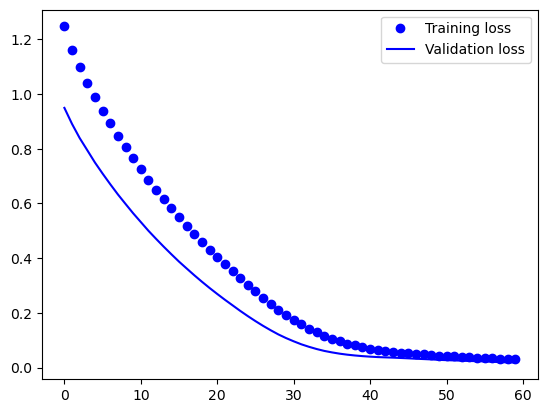

In [52]:
#HISTORY PLOT
epochs_steps = [*range(0, len(history.history['loss']))]

# MAKE PREDICTIONS
train_predict = model.predict(trainX).squeeze()
test_predict = model.predict(testX).squeeze()
print(trainX.shape, train_predict.shape,trainY.shape,testX.shape, test_predict.shape,testY.shape)

#COMPUTE RMSE
print(trainY.shape, train_predict.shape)
train_rmse = np.sqrt(mean_squared_error(trainY, train_predict))
test_rmse = np.sqrt(mean_squared_error(testY, test_predict))
print(np.mean((trainY-train_predict)**2.0))
print(np.mean((testY-test_predict)**2.0))

print('Train MSE = %.5f RMSE = %.5f' % (train_rmse**2.0,train_rmse))
print('Test MSE = %.5f RMSE = %.5f' % (test_rmse**2.0,test_rmse))    

# PLOTLY PLOT
plotly_line_plot([epochs_steps,epochs_steps],[history.history['loss'],history.history['val_loss']],title="Sunspots per month since 1749-01",x_label="training epochs",y_label="loss (MSE)")

print(history.history['loss'])
# SIMPLE PLOT 
plt.figure()
plt.plot(epochs_steps, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs_steps, history.history['val_loss'], 'b', label='Validation loss')
plt.legend()


In [53]:
# GET DATA
# GENERATE PLOTLY FIGURE

fig = px.scatter(x=trainY,y=train_predict,height=600,width=800)
fig.add_scatter(x=testY,y=test_predict,mode="markers")
fig.add_scatter(x=trainY,y=trainY, mode='lines')

fig.update_layout(
    xaxis_title="y_pred",
    yaxis_title="y_data",
    template="plotly_white",
    showlegend=False
)

fig.show()

(81,) (9,)


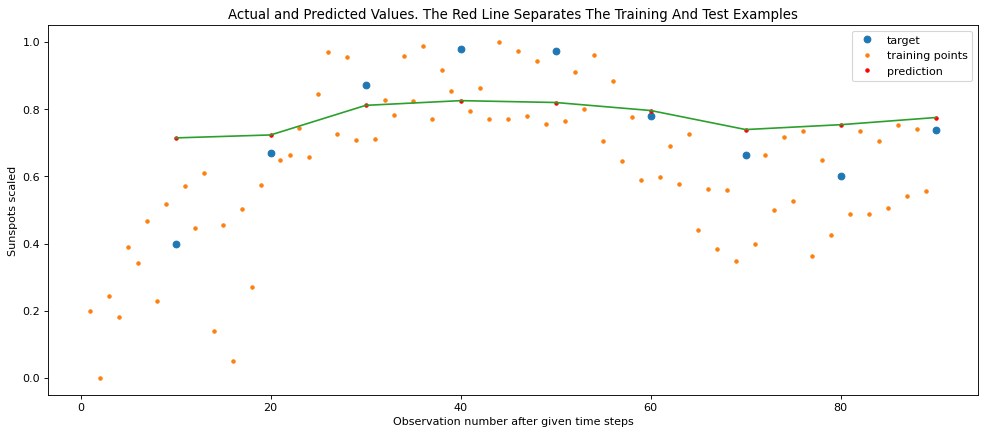

In [54]:
# PLOT THE RESULT
def plot_result(trainY, testY, train_predict, test_predict):
    plt.figure(figsize=(15, 6), dpi=80)
    #ORIGINAL DATA
    print(X.shape,Y.shape)
    plt.plot(Y_ind, Y,'o', label='target')
    plt.plot(X_ind, X,'.', label='training points');     
    plt.plot(Y_ind, train_predict,'r.', label='prediction');    
    plt.plot(Y_ind, train_predict,'-');    
    plt.legend()
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    plt.show()
plot_result(trainY, testY, train_predict, test_predict)